In [1]:
import os

from zoo.common.nncontext import *

sc = init_nncontext("Anomaly Detection-Temperature")
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing

Prepending /home/user/anaconda3/lib/python3.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /home/user/anaconda3/lib/python3.7/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-jar-with-dependencies.jar to BIGDL_JARS
Prepending /home/user/anaconda3/lib/python3.7/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
pyspark_submit_args is:  --driver-class-path /home/user/anaconda3/lib/python3.7/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-jar-with-dependencies.jar:/home/user/anaconda3/lib/python3.7/site-packages/bigdl/share/lib/bigdl-0.12.1-jar-with-dependencies.jar pyspark-shell 
Populating the interactive namespace from numpy and matplotlib


In [2]:
from zoo.pipeline.api.keras.layers import Dense, Dropout, LSTM
from zoo.pipeline.api.keras.models import Sequential

In [3]:
columns_list = ['serial','division','ddust','dust','temperature','relative_humidity',
               'measure_time', 'timestamp']

try:
    dataset_path = "../data/Seoul-sensor-data/S-DoT_NATURE_2020.04.01-04.30.csv"
    df = pd.read_csv(dataset_path, encoding='cp949')
    df.drop(columns = df.columns[:4], axis=1, inplace=True)
    df.drop(columns = df.columns[6:22], axis=1, inplace=True)
    df.columns = columns_list
except Exception as e:
    print("CSV doesn't exist")
    
dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.05.01-05.31.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[:4], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:22], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)

dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.06.01-06.30.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[:4], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:22], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)

dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.07.01-07.31.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[:4], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:22], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)

dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.08.01-08.31.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[:4], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:22], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)

dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.09.01-09.30.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[0], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:-2], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)

dataset_path = '../data/Seoul-sensor-data/S-DoT_NATURE_2020.10.01-10.31.csv'
df_temp = pd.read_csv(dataset_path, encoding='cp949')
df_temp.drop(columns = df_temp.columns[0], axis=1, inplace=True)
df_temp.drop(columns = df_temp.columns[6:-2], axis=1, inplace=True)
df_temp.columns = columns_list
df = pd.concat([df, df_temp], ignore_index = True)


In [4]:
#df.iloc[8, 23]

df['timestamp'].dropna()
df['temperature'] = pd.to_numeric(df['temperature'], errors = 'coerce') 
df = df.astype({'temperature': 'float64'})



In [5]:
print(df.info())
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024062 entries, 0 to 4024061
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   serial             object 
 1   division           int64  
 2   ddust              float64
 3   dust               float64
 4   temperature        float64
 5   relative_humidity  float64
 6   measure_time       object 
 7   timestamp          object 
dtypes: float64(4), int64(1), object(3)
memory usage: 245.6+ MB
None
        serial  division  ddust  dust  temperature  relative_humidity  \
0  V02Q1940043         1   15.0  26.0         14.0               37.0   
1  V02Q1940043         1   21.0  37.0         16.6               28.0   
2  V02Q1940043         1   18.0  39.0         15.0               16.0   
3  V02Q1940043         1    2.0   3.0          9.0               49.0   
4  V02Q1940043         1    3.0   5.0          7.7               53.0   
5  V02Q1940043         1    8.0  16.0         16.0           

In [6]:
node_mask = (df.serial == 'V02Q1940043')
df_node = df.loc[node_mask, :]
print(df_node['timestamp'].head(10))

0     2020.4.1 1:00
1    2020.4.1 12:00
2    2020.4.1 18:00
3     2020.4.2 0:00
4     2020.4.2 6:00
5    2020.4.2 12:00
6    2020.4.2 15:00
7    2020.4.2 23:00
8     2020.4.3 4:00
9    2020.4.3 12:00
Name: timestamp, dtype: object


In [7]:
df_node

,serial,division,ddust,dust,temperature,relative_humidity,measure_time,timestamp
0,V02Q1940043,1,15.0,26.0,14.0,37.0,2020.4.1 1:00,2020.4.1 1:00
1,V02Q1940043,1,21.0,37.0,16.6,28.0,2020.4.1 12:00,2020.4.1 12:00
2,V02Q1940043,1,18.0,39.0,15.0,16.0,2020.4.1 18:00,2020.4.1 18:00
3,V02Q1940043,1,2.0,3.0,9.0,49.0,2020.4.2 0:00,2020.4.2 0:00
4,V02Q1940043,1,3.0,5.0,7.7,53.0,2020.4.2 6:00,2020.4.2 6:00
...,...,...,...,...,...,...,...,...
4020353,V02Q1940043,1,3.0,5.0,17.2,51.0,2020-10-31 19:00:00,2020-10-31 19:00:00
4020911,V02Q1940043,1,3.0,5.0,17.0,51.0,2020-10-31 20:00:00,2020-10-31 20:00:00
4022124,V02Q1940043,1,3.0,4.0,17.1,49.0,2020-10-31 21:00:00,2020-10-31 21:00:00
4022391,V02Q1940043,1,3.0,4.0,17.0,48.0,2020-10-31 22:00:00,2020-10-31 22:00:00


In [8]:
print(df_node['temperature'].mean())

22.262323943661947


/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


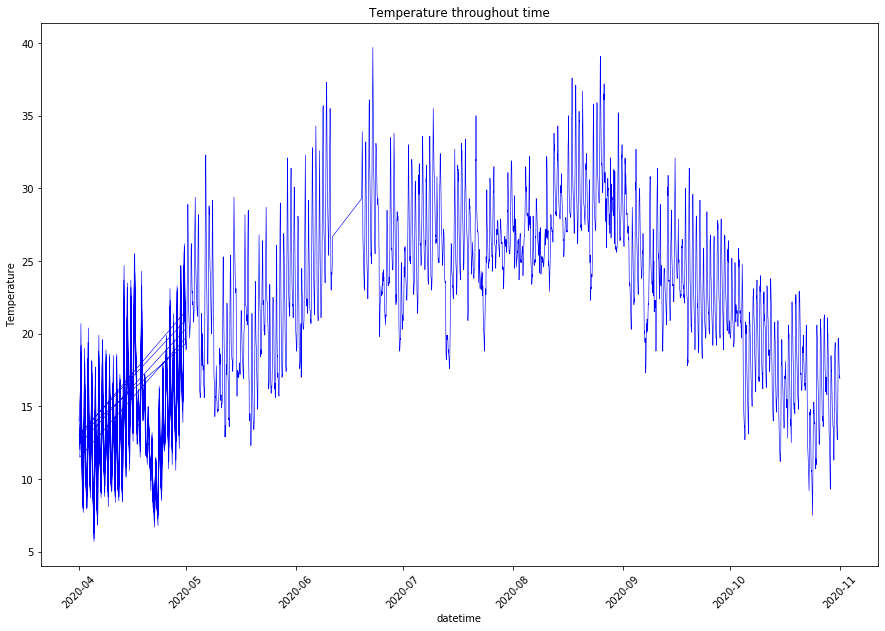

In [9]:
df_node['datetime'] = pd.to_datetime(df_node['timestamp'])

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df_node['datetime'], df_node['temperature'], color='blue', linewidth=0.6)
ax.set_title('Temperature throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('Temperature')
plt.show()

In [10]:
df_node['hours'] = df_node['datetime'].dt.hour
df_node['daylight'] = ((df_node['hours'] >= 7) & (df_node['hours'] <= 22)).astype(int)
df_node['DayOfTheWeek'] = df_node['datetime'].dt.dayofweek
df_node['WeekDay'] = (df_node['DayOfTheWeek'] < 5).astype(int)


# Anomaly estimated population
outliers_fraction = 0.01

df_node['time_epoch'] = (df_node['datetime'].astype(np.int64)/100000000000).astype(np.int64)

df_node['categories'] = df_node['WeekDay']*2 + df_node['daylight']
a = df_node.loc[df_node['categories'] == 0, 'temperature']
b = df_node.loc[df_node['categories'] == 1, 'temperature']
c = df_node.loc[df_node['categories'] == 2, 'temperature']
d = df_node.loc[df_node['categories'] == 3, 'temperature']

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



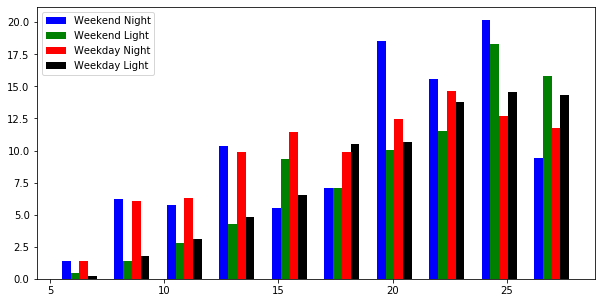

In [11]:
figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()
plt.show()

In [12]:
#Preparing the data for LSTM model
data_n = df_node[['temperature', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
standard_scaler = preprocessing.StandardScaler()
np_scaled = standard_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [13]:
#Important parameters and training/Test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#Training data
x_train = data_n[0:-prediction_time-testdatacut].to_numpy()
y_train = data_n[prediction_time:-testdatacut  ][0].to_numpy()

#Test data
x_test = data_n[0-testdatacut:-prediction_time].to_numpy()
y_test = data_n[prediction_time-testdatacut:  ][0].to_numpy()

In [14]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (3727, 50, 5)
y_train (3727,)
x_test (1000, 50, 5)
y_test (1000,)


In [15]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_shape=(x_train.shape[1], x_train.shape[-1]),
    output_dim=30,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    10,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

creating: createZooKerasSequential
creating: createZooKerasLSTM
creating: createZooKerasDropout
creating: createZooKerasLSTM
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError


In [16]:
%%time
# Train the model
print("Training begins.")
model.fit(
    x_train,
    y_train,
    batch_size=1024,
    nb_epoch=20)
print("Training completed.")

Training begins.
Training completed.
CPU times: user 30.2 ms, sys: 7.51 ms, total: 37.7 ms
Wall time: 37.4 s


In [17]:
# create the list of difference between prediction and test data
diff=[]
ratio=[]
predictions = model.predict(x_test)
p = predictions.collect()
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [18]:
print(p)

[array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], dtype=float32), array([nan], 

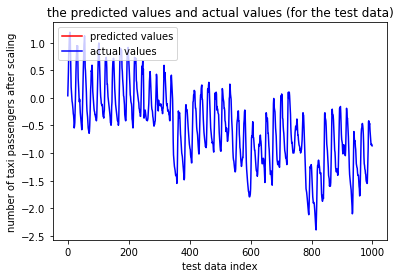

In [19]:
# plot the predicted values and actual values (for the test data)
fig, axs = plt.subplots()

axs.plot(p,color='red', label='predicted values')
axs.plot(y_test,color='blue', label='actual values')
axs.set_title('the predicted values and actual values (for the test data)')

plt.xlabel('test data index')
plt.ylabel('number of taxi passengers after scaling')
plt.legend(loc='upper left')
plt.show()